![title](title.png)

# 🎯 Objective

The objective of this project is to support Santé publique France in improving the Open Food Facts database — a widely accessible open-source platform that helps individuals and organizations assess the nutritional quality of food products.  

Currently, adding a product to the database requires manually filling in numerous fields, leading to data entry errors and a significant number of missing values. To address this, Santé publique France aims to implement a suggestion or auto-completion system that assists users in more efficiently populating the database.  

The first step involves thoroughly cleaning and exploring the data to assess the feasibility of such a system. This includes identifying key variables, handling missing data and outliers, and ensuring the analysis remains adaptable to future database updates.  

The ultimate goal is to lay the groundwork for a reliable, automated system that reduces errors, enhances data quality, and maintains compliance with GDPR principles — ensuring transparency and trustworthiness for public use.  

# 0️⃣ Step 0: Configuration and general data overview


____


## Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.impute import KNNImputer

## Functions 

In [75]:

#------------------------------ Drop high missing columns (over 50 %) ------------------------------ #

def drop_high_missing_columns(df, threshold=50):
    df_cleand = df.copy()
    df_cleand = df_cleand.loc[:, (df_cleand.isnull().mean() * 100) <= threshold]
    return df_cleand

#------------------------------ Shows % of missing values  ------------------------------ #

def percent_missing(df, percent=0):
    # Calculating
    result = 100 * df.isnull().sum() / len(df)
    result = result[result > percent]
    
    # Sorting
    result = result.sort_values(ascending=False)
    
    # DF creation
    result = pd.DataFrame(result).reset_index()
    result.columns = ['Column', 'Percentage missing'] 

    if result.empty :
        print('There is no missing values in the selected DataFrame')
        return None
    return result


#------------------------------ Removes negative values from numeric columns in a DataFrame and replace them with None ------------------------------ #

def remove_negative_values(df):
    numeric_cols = df.select_dtypes(include='number').columns
    df_cleand = df.copy()
    df_cleand[numeric_cols] = df_cleand[numeric_cols].apply(lambda x: x.where(x >= 0, None))
    return df_cleand


#------------------------------ Detect outliers in the DataFrame ------------------------------ #

def detect_outliers(df,q1=0.25, q3=0.75):

    num_cols = df.select_dtypes(include='number').columns
    
    outliers_count = {} 
    
    for col in num_cols:

        Q1 = df[col].quantile(q1)
        Q3 = df[col].quantile(q3)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        
        outliers_count[col] = outliers.shape[0]
    
    return outliers_count


#------------------------------ Print the shape of the DataFrame ------------------------------ #

def print_shape(df):
    print(f'\nThere are {df.shape[0]} rows and {df.shape[1]} columns in the Data Frame.\n')



def plot_boxplots(df, columns=None, ncols=3, figsize_per_plot=(5, 5)):

    if columns is None:
        columns = df.select_dtypes(include='number').columns
 
    nrows = (len(columns) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                             figsize=(figsize_per_plot[0] * ncols, figsize_per_plot[1] * nrows))
    axes = axes.flatten()
    
    for i, col in enumerate(columns):
        sns.boxplot(data=df[col], ax=axes[i])
        axes[i].set_title(col)

    for j in range(len(columns), len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()



#------------------------------ Replace high values by given cap_value  ------------------------------ #

def cap_values(column, cap_value):

    if isinstance(column, pd.Series): 
        return column.apply(lambda x: min(x, cap_value))
    elif isinstance(column, list):  # If the input is a list
        return [min(x, cap_value) for x in column]
    else:
        raise TypeError("Input should be a pandas Series or a list.")


#------------------------------ Calculating energy  ------------------------------ #

def calculate_energy(df):
    required_columns = ['carbohydrates_100g', 'proteins_100g', 'fat_100g']
    
    df[required_columns] = df[required_columns] + 0.001

    energy = (4 * df['carbohydrates_100g'] + 
              4 * df['proteins_100g'] + 
              9 * df['fat_100g'])
    
    energy_in_kJ = (energy * 4.184).round(2)
    
    return energy_in_kJ

#------------------------------ Fill missing values with median  ------------------------------ #

def fill_missing_with_median(df):

    df_filled = df.copy()
    numeric_columns = df_filled.select_dtypes(include=['number']).columns
    
    for col in numeric_columns:
        df_filled[col] = df_filled[col].fillna(df[col].median())
    
    return df_filled

#------------------------------ Fill missing values with KNN method  ------------------------------ #


def knn_impute(df, target_column, features, n_neighbors=5, mapping=None):

    if mapping:
        df[target_column] = df[target_column].map(mapping)


    impute_data = df[features + [target_column]]
    

    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputed_data = imputer.fit_transform(impute_data)

    imputed_df = pd.DataFrame(imputed_data, columns=features + [target_column])


    if mapping:
        df[target_column] = imputed_df[target_column].round().clip(
            min(mapping.values()), 
            max(mapping.values())
        )
        reverse_mapping = {v: k for k, v in mapping.items()}
        df[target_column] = df[target_column].map(reverse_mapping)
    else:
        df[target_column] = imputed_df[target_column]

    return df

#------------------------------ Drop high missing rows (over 10 columns) ------------------------------ #

def delete_high_missing_rows(df,g = 10 ):
    df_cleaned = df.copy()
    rows_to_delete = df_cleaned[df_cleaned.isnull().sum(axis=1) > g].index  
    df_cleaned = df_cleaned.drop(index=rows_to_delete) 
    print(f'\n{len(rows_to_delete)} rows were deleted sucsecefully!\n')
    return df_cleaned


#------------------------------ Replace fiber with zero in filtered data ------------------------------ #
def replace_fiber_with_zero(df):
    rows_to_fill = df[df['product_name'].str.contains('soda|oil|water|sugar|tea|coffee|honey|sirop|juice|wine|beer', case=False, na=False) & df['fiber_100g'].isna()].index
    
    df.loc[rows_to_fill, 'fiber_100g'] = 0
    print(f'\n{len(rows_to_fill)} rows were replaced with zeros sucsecefully!\n')
    return df

#------------------------------ Plot distribution before vs after ------------------------------ #

def plot_distribution_before_after(df_before, df_after, columns):
    num_columns = len(columns)
    
    if num_columns == 1:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes = [axes] 
    else:
        fig, axes = plt.subplots(num_columns, 2, figsize=(12, 5 * num_columns))
    
    for i, column in enumerate(columns):
        # Before
        sns.histplot(df_before[column], kde=True, ax=axes[i][0], color='blue')
        axes[i][0].set_title(f"Before Imputation - {column}")
        axes[i][0].set_xlabel(column)
        axes[i][0].set_ylabel("Frequency")
        
        # After
        sns.histplot(df_after[column], kde=True, ax=axes[i][1], color='green')
        axes[i][1].set_title(f"After Imputation - {column}")
        axes[i][1].set_xlabel(column)
        axes[i][1].set_ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()

## Load data

In [3]:

df = pd.read_csv('fr.openfoodfacts.org.products.csv',sep='\t', low_memory=False) 
pd.set_option('display.max_columns', None)

## Data overview

In [4]:
df.head(3)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,allergens_fr,traces,traces_tags,traces_fr,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_uk,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,butyric-acid_100g,caproic-acid_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,behenic-acid_100g,lignoceric-acid_100g,cerotic-acid_100g,montanic-acid_100g,melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,elaidic-acid_100g,gondoic-acid_100g,mead-acid_100g,erucic-acid_100g,nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN,NaN,NaN,NaN,28 g (1 ONZ),NaN,0.0,[ bananas -> en:bananas ]

In [5]:
print_shape(df)


There are 320772 rows and 162 columns in the Data Frame.



In [6]:
df.describe()

,no_nutriments,additives_n,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,nutrition_grade_uk,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,butyric-acid_100g,caproic-acid_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,behenic-acid_100g,lignoceric-acid_100g,cerotic-acid_100g,montanic-acid_100g,melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,elaidic-acid_100g,gondoic-acid_100g,mead-acid_100g,erucic-acid_100g,nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
count,0.0,248939.000000,248939.000000,0.0,248939.000000,0.0,0.0,2.611130e+05,857.000000,243891.000000,229554.000000,0.0,0.0,1.0,2.000000,4.000000,1.0,1.0,1.0,24.000000,23.000000,0.0,0.0,1.0,0.0,22823.000000,22859.000000,841.000000,186.000000,38.000000,78.000000,188.000000,149.000000,8.000000,24.000000,23.000000,21.000000,13.000000,0.0,1.400000e+01,0.0,0.0,0.0,143298.000000,144090.000000,243588.000000,244971.000000,72.000000,26.000000,38.000000,262.000000,4.000000,11.000000,266.000000,414.000000,200886.000000,259922.000000,27.000000,16.000000,9.000000,255510.000000,255463.000000,4133.000000,137554.000000,34.000000,7057.000000,1340.000000,918.000000,140867.000000,11154.000000,10815.000000,11729.000000,6784.000000,5240.000000,3042.000000,5.300000e+03,330.000000,2483.000000,38.000000,81.000000,24748.000000,158.000000,141050.000000,5845.000000,140462.000000,6253.000000,3929.000000,2106.000000,1620.000000,79.000000,1168.000000,20.000000,11.000000,259.000000,78.000000,29.000000,49.000000,3036.000000,165.000000,948.000000,0.0,268.000000,221210.000000,221210.000000,0.0,0.0
mean,NaN,1.936024,0.019659,NaN,0.055246,NaN,NaN,1.141915e+03,585.501214,12.730379,5.129932,NaN,NaN,7.4,6.040000,36.136182,18.9,8.1,3.0,10.752667,10.673913,NaN,NaN,61.0,NaN,10.425055,6.312493,3.182103,2.250285,3.186553,1.635462,16.229144,3.823819,0.057000,0.153842,0.061567,40.192857,25.123077,NaN,1.357143e-06,NaN,NaN,NaN,0.073476,0.020071,32.073981,16.003484,11.841667,2.878846,25.897368,6.354084,24.325000,12.163636,31.925000,49.790389,2.862111,7.075940,4.658148,2.506250,0.021678,2.028624,0.798815,7.838105,0.000397,0.518715,0.000008,0.056705,0.034219,0.023367,0.325574,0.259007,0.020303,0.023378,0.006898,0.205856,8.938696e-05,0.121290,0.072138,0.013123,0.119052,0.424635,0.092638,0.125163,0.617282,0.003652,0.534143,0.007950,0.025794,0.003014,0.012161,0.003126,0.001690,0.000401,0.000427,1.594563,0.145762,6.425698,31.458587,15.412121,49.547785,NaN,341.700764,9.165535,9.058049,NaN,NaN
std,NaN,2.502019,0.140524,NaN,0.269207,NaN,NaN,6.447154e+03,712.809943,17.578747,8.014238,NaN,NaN,NaN,0.226274,24.101433,NaN,NaN,NaN,4.019993,3.379647,NaN,NaN,NaN,NaN,17.0761

In [7]:
# Ckecking for duplicated values

df.duplicated().sum()

np.int64(0)

In [8]:
# Showing alll numerical columns

num_col = df.select_dtypes(include='number').columns.to_list()
print(f'There are: {len(num_col)} numerical columns in the DataFrame\n ')
print(num_col)

There are: 106 numerical columns in the DataFrame
 
['no_nutriments', 'additives_n', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil', 'nutrition_grade_uk', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g', 'butyric-acid_100g', 'caproic-acid_100g', 'caprylic-acid_100g', 'capric-acid_100g', 'lauric-acid_100g', 'myristic-acid_100g', 'palmitic-acid_100g', 'stearic-acid_100g', 'arachidic-acid_100g', 'behenic-acid_100g', 'lignoceric-acid_100g', 'cerotic-acid_100g', 'montanic-acid_100g', 'melissic-acid_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g', 'alpha-linolenic-acid_100g', 'eicosapentaenoic-acid_100g', 'docosahexaenoic-acid_100g', 'omega-6-fat_100g', 'linoleic-acid_100g', 'arachidonic-acid_100g', 'gamma-linolenic-acid_100g', 'dihomo-gamma-linolenic-acid_100g', 'omega-9-fat_100g', 'oleic-acid_100g', 'elaidic-acid_100g', 'gondoic-acid_100g

In [9]:
# Showing alll categorical columns

cat_col = df.select_dtypes(include='object').columns.to_list()
print(f'There are: {len(cat_col)} categorical columns in the DataFrame\n ')
print(cat_col)

There are: 56 categorical columns in the DataFrame
 
['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_fr', 'ingredients_text', 'allergens', 'allergens_fr', 'traces', 'traces_tags', 'traces_fr', 'serving_size', 'additives', 'additives_tags', 'additives_fr', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_fr', 'pnns_groups_1', 'pnns_groups_2', 'states', 'states_tags', 'states_fr', 'main_category', 'main_category_fr', 'image_url', 'image_small_url']


## Calculating missing values (over 50%)

### Numerical columns

In [10]:
percent_missing(df[num_col],50)

,Column,Percentage missing
0,no_nutriments,100.000000
1,lignoceric-acid_100g,100.000000
2,glycemic-index_100g,100.000000
3,chlorophyl_100g,100.000000
4,ingredients_from_palm_oil,100.000000
...,...,...
87,iron_100g,56.211265
88,vitamin-c_100g,56.085007
89,calcium_100g,56.027958
90,trans-fat_100g,55.327148


### Categorical columns

In [11]:
percent_missing(df[cat_col],50)

,Column,Percentage missing
0,allergens_fr,99.994077
1,cities,99.992830
2,ingredients_from_palm_oil_tags,98.492699
3,ingredients_that_may_be_from_palm_oil_tags,96.353796
4,first_packaging_code_geo,94.138204
5,cities_tags,93.665283
6,origins_tags,93.093849
7,origins,93.082314
8,traces_tags,92.415485
9,traces_fr,92.408315


## Visualizing all missing values

<Axes: >

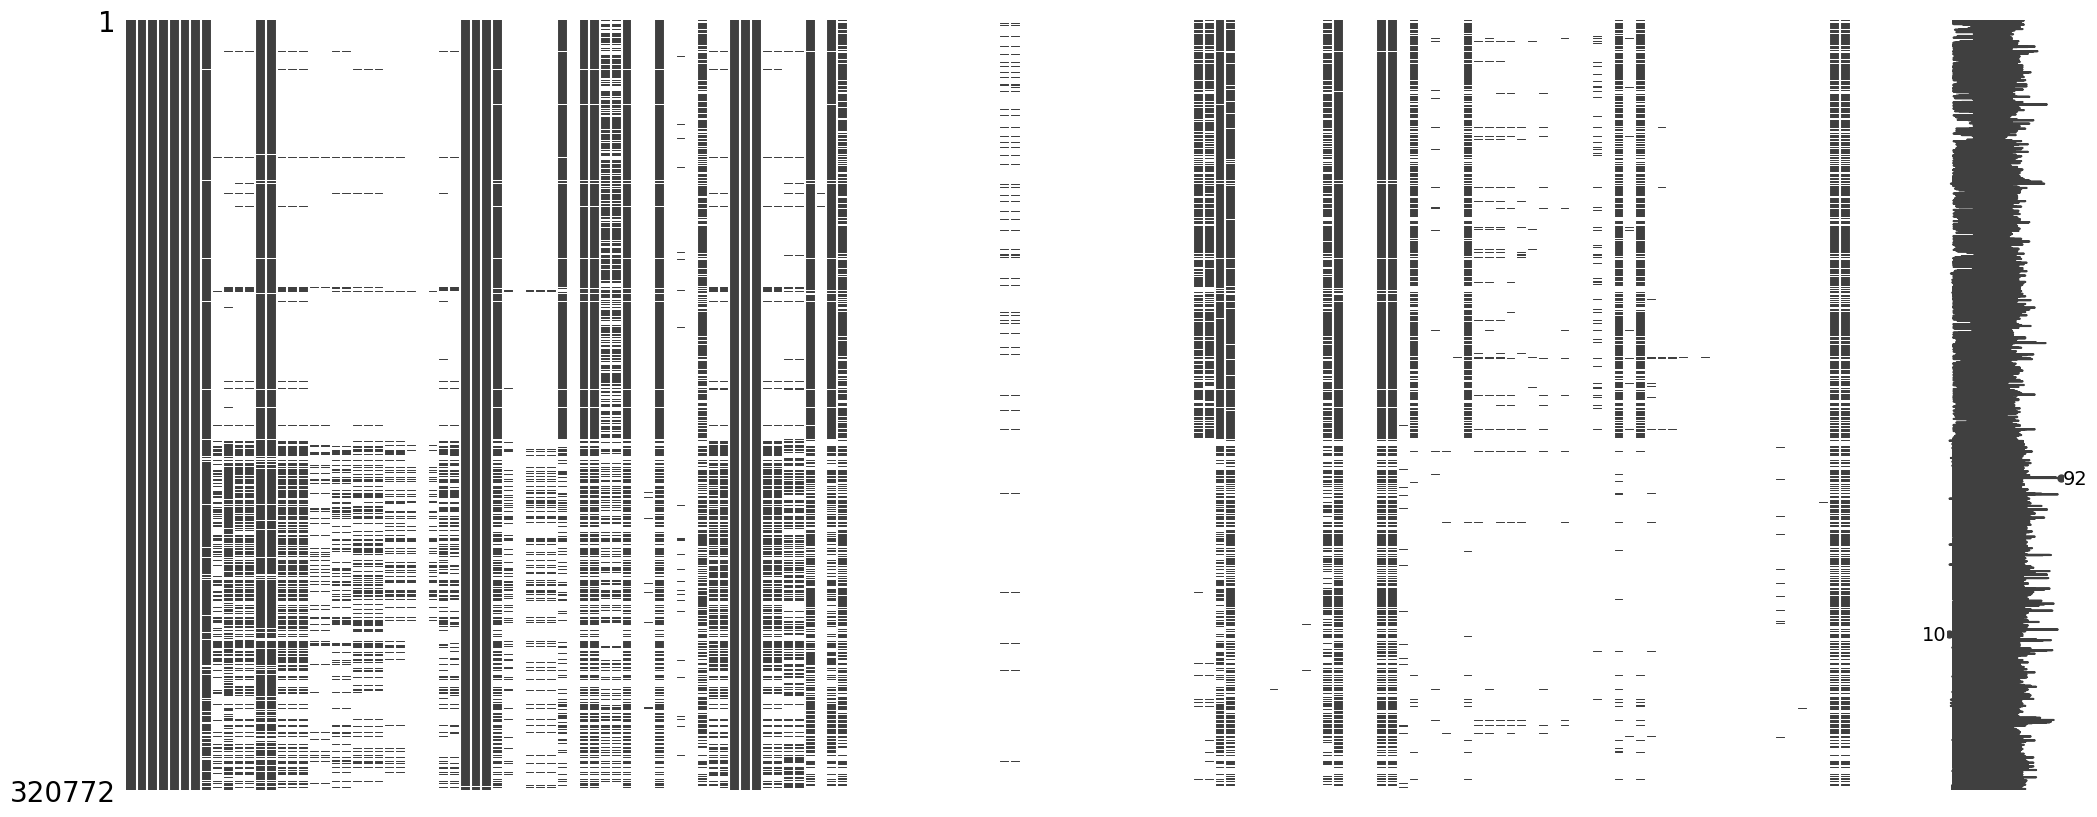

In [12]:
msno.matrix(df)

## ℹ️ Observation for Step 0: Initial Data Review

Those outputs show the frequency of missing data percentages across the columns. The most common percentage is close to **100%**, indicating many columns are largely incomplete. At all **127 columns have more than 50% missing values**.

Some of the features (mostly with *`_100g `*in their names) have the highest number of missing values** - these represent nutritional content per 100g of products. Given the large amount of missing data in these features, it would be reasonable to remove them from the dataset.

# 1️⃣ Step 1: Clean and filter features and products


___

## Choosing target

_____

As the target, **nutrition_grade_fr** were selected as representative indicators to understand the global distribution of data in the dataset.

In [13]:
df['nutrition_grade_fr'].unique()

array([nan, 'd', 'b', 'c', 'a', 'e'], dtype=object)

In [14]:
target_col = df['nutrition_grade_fr']

In [15]:
df = df.drop('nutrition_grade_fr', axis=1)

In [16]:
target_col.info()

<class 'pandas.core.series.Series'>
RangeIndex: 320772 entries, 0 to 320771
Series name: nutrition_grade_fr
Non-Null Count   Dtype 
--------------   ----- 
221210 non-null  object
dtypes: object(1)
memory usage: 2.4+ MB


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 161 entries, code to water-hardness_100g
dtypes: float64(106), object(55)
memory usage: 394.0+ MB


## Removing missing data 

### Removing columns missing over 50 %

In [18]:
df_cleaned = drop_high_missing_columns(df)
print(f'Number of columns before: {df.shape[1]}')
print(f'Number of columns after: {df_cleaned.shape[1]}')
print(f'Total removed columns: {df.shape[1] - df_cleaned.shape[1]}')

Number of columns before: 161
Number of columns after: 33
Total removed columns: 128


In [19]:
percent_missing(df_cleaned)

,Column,Percentage missing
0,fiber_100g,37.374210
1,serving_size,34.118003
2,nutrition-score-uk_100g,31.038245
3,nutrition-score-fr_100g,31.038245
4,saturated-fat_100g,28.437021
5,carbohydrates_100g,24.061951
6,fat_100g,23.967491
7,sugars_100g,23.630803
8,additives,22.404387
9,ingredients_that_may_be_from_palm_oil_n,22.393787


## Select data

For further analysis, we need to choose the most meaningful data.

____

In [20]:
# Visualizing all columns

print('\n'.join(df_cleaned.columns))

code
url
creator
created_t
created_datetime
last_modified_t
last_modified_datetime
product_name
brands
brands_tags
countries
countries_tags
countries_fr
ingredients_text
serving_size
additives_n
additives
ingredients_from_palm_oil_n
ingredients_that_may_be_from_palm_oil_n
states
states_tags
states_fr
energy_100g
fat_100g
saturated-fat_100g
carbohydrates_100g
sugars_100g
fiber_100g
proteins_100g
salt_100g
sodium_100g
nutrition-score-fr_100g
nutrition-score-uk_100g


**We selected these variables based on their relevance to the project’s goal:**  

---



In [21]:
key_variables = [

    # Nutritional information
    'energy_100g',
    'fat_100g',
    'sugars_100g',
    'proteins_100g',
    'saturated-fat_100g',
    'fiber_100g',
    'salt_100g',
    'nutrition-score-fr_100g',
    'carbohydrates_100g',

    # Ingredients
    'ingredients_text',
    'additives',

    # Products
    'product_name',
    'countries_fr'
]

 **We removed these columns:**  

---


**1. Ingredients:**  

- **`ingredients_from_palm_oil_n`,`ingredients_that_may_be_from_palm_oil_n`** - may have not big impact on recommendation system
- **`'sodium_100g'`** - has correlation with salt, so not useful

---

**2. Duplicate information:**  

- **`additives_fr`** , **`additives_tags`**, **`additives_n`**— kept the main `additives` column.
- **`nutrition-score-uk_100g `** — we have `nutrition-score-fr`.
- - **`countries_tags`** and **`countries`** - we have **`countries_fr`**

---

**3. Technical data:**  

  
- **`brands`**, **`brands_tags`**  — may be irrelevant.  
- **`states`**, **`states_tags`**, **`states_fr`** — track data status but are irrelevant.  
- **`url`**, **`code`**, **`created_datetime`**, **`created_t`**, **`creator`**, **`last_modified_datetime`** — are irrelevant for the recommendation system.  

---


In [22]:
df_selected = df_cleaned[key_variables]
df_selected.head(3)

,energy_100g,fat_100g,sugars_100g,proteins_100g,saturated-fat_100g,fiber_100g,salt_100g,nutrition-score-fr_100g,carbohydrates_100g,ingredients_text,additives,product_name,countries_fr
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Farine de blé noir,France
1,2243.0,28.57,14.29,3.57,28.57,3.6,0.000,14.0,64.29,"Bananas, vegetable oil (coconut oil, corn oil ...",[ bananas -> en:bananas ] [ vegetable-oil -...,Banana Chips Sweetened (Whole),États-Unis
2,1941.0,17.86,17.86,17.86,0.00,7.1,0.635,0.0,60.71,"Peanuts, wheat flour, sugar, rice flour, tapio...",[ peanuts -> en:peanuts ] [ wheat-flour -> ...,Peanuts,États-Unis


In [23]:
print_shape(df_selected)


There are 320772 rows and 13 columns in the Data Frame.



# 2️⃣ Step 2: Identify and handle outliers 

## Removing negative values
____

In [24]:
df_selected.describe()

,energy_100g,fat_100g,sugars_100g,proteins_100g,saturated-fat_100g,fiber_100g,salt_100g,nutrition-score-fr_100g,carbohydrates_100g
count,2.611130e+05,243891.000000,244971.000000,259922.000000,229554.000000,200886.000000,255510.000000,221210.000000,243588.000000
mean,1.141915e+03,12.730379,16.003484,7.075940,5.129932,2.862111,2.028624,9.165535,32.073981
std,6.447154e+03,17.578747,22.327284,8.409054,8.014238,12.867578,128.269454,9.055903,29.731719
min,0.000000e+00,0.000000,-17.860000,-800.000000,0.000000,-6.700000,0.000000,-15.000000,0.000000
25%,3.770000e+02,0.000000,1.300000,0.700000,0.000000,0.000000,0.063500,1.000000,6.000000
50%,1.100000e+03,5.000000,5.710000,4.760000,1.790000,1.500000,0.581660,10.000000,20.600000
75%,1.674000e+03,20.000000,24.000000,10.000000,7.140000,3.600000,1.374140,16.000000,58.330000
max,3.251373e+06,714.290000,3520.000000,430.000000,550.000000,5380.000000,64312.800000,40.000000,2916.670000


As we can see, there are some negative values in columns such as sugars_100g, proteins_100g, fiber_100g, and nutrition-score-fr_100g. Therefore, we need to replace them with None.

In [25]:
# Replace any negative values from the dataframe to None
df_cleaned_neg = remove_negative_values(df_selected.drop(columns='nutrition-score-fr_100g'))

In [26]:
df_cleaned_neg['nutrition-score-fr_100g'] = df_selected['nutrition-score-fr_100g'].values

In [27]:
df_cleaned_neg.describe().round(2)

,energy_100g,fat_100g,sugars_100g,proteins_100g,saturated-fat_100g,fiber_100g,salt_100g,carbohydrates_100g,nutrition-score-fr_100g
count,261113.00,243891.00,244964.00,259919.00,229554.00,200885.00,255510.00,243588.00,221210.00
mean,1141.91,12.73,16.00,7.08,5.13,2.86,2.03,32.07,9.17
std,6447.15,17.58,22.33,8.20,8.01,12.87,128.27,29.73,9.06
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-15.00
25%,377.00,0.00,1.30,0.70,0.00,0.00,0.06,6.00,1.00
50%,1100.00,5.00,5.71,4.76,1.79,1.50,0.58,20.60,10.00
75%,1674.00,20.00,24.00,10.00,7.14,3.60,1.37,58.33,16.00
max,3251373.00,714.29,3520.00,430.00,550.00,5380.00,64312.80,2916.67,40.00


## Identifying other outliers


The maximum values in several columns appear unrealistic and likely erroneous:

1.	energy_100g: 3,251,373 kJ is far too high.
2.	fat_100g: 714.29 grams per 100g is impossible.
3.	sugars_100g: 3,52 grams per 100g exceeds total weight.
4.	proteins_100g: 430 grams per 100g is highly unrealistic.
5.	saturated-fat_100g: 550 grams per 100g is not possible.
6.	fiber_100g: 5,380 grams per 100g is extremely high.
7.	salt_100g: 64,312.8 grams per 100g is an order of magnitude too high.
8.	carbohydrates_100g: 2916.6 grams per 100g is far too high.


**These values are likely errors and should be corrected or removed.**

### Visualizing outliers with box plots

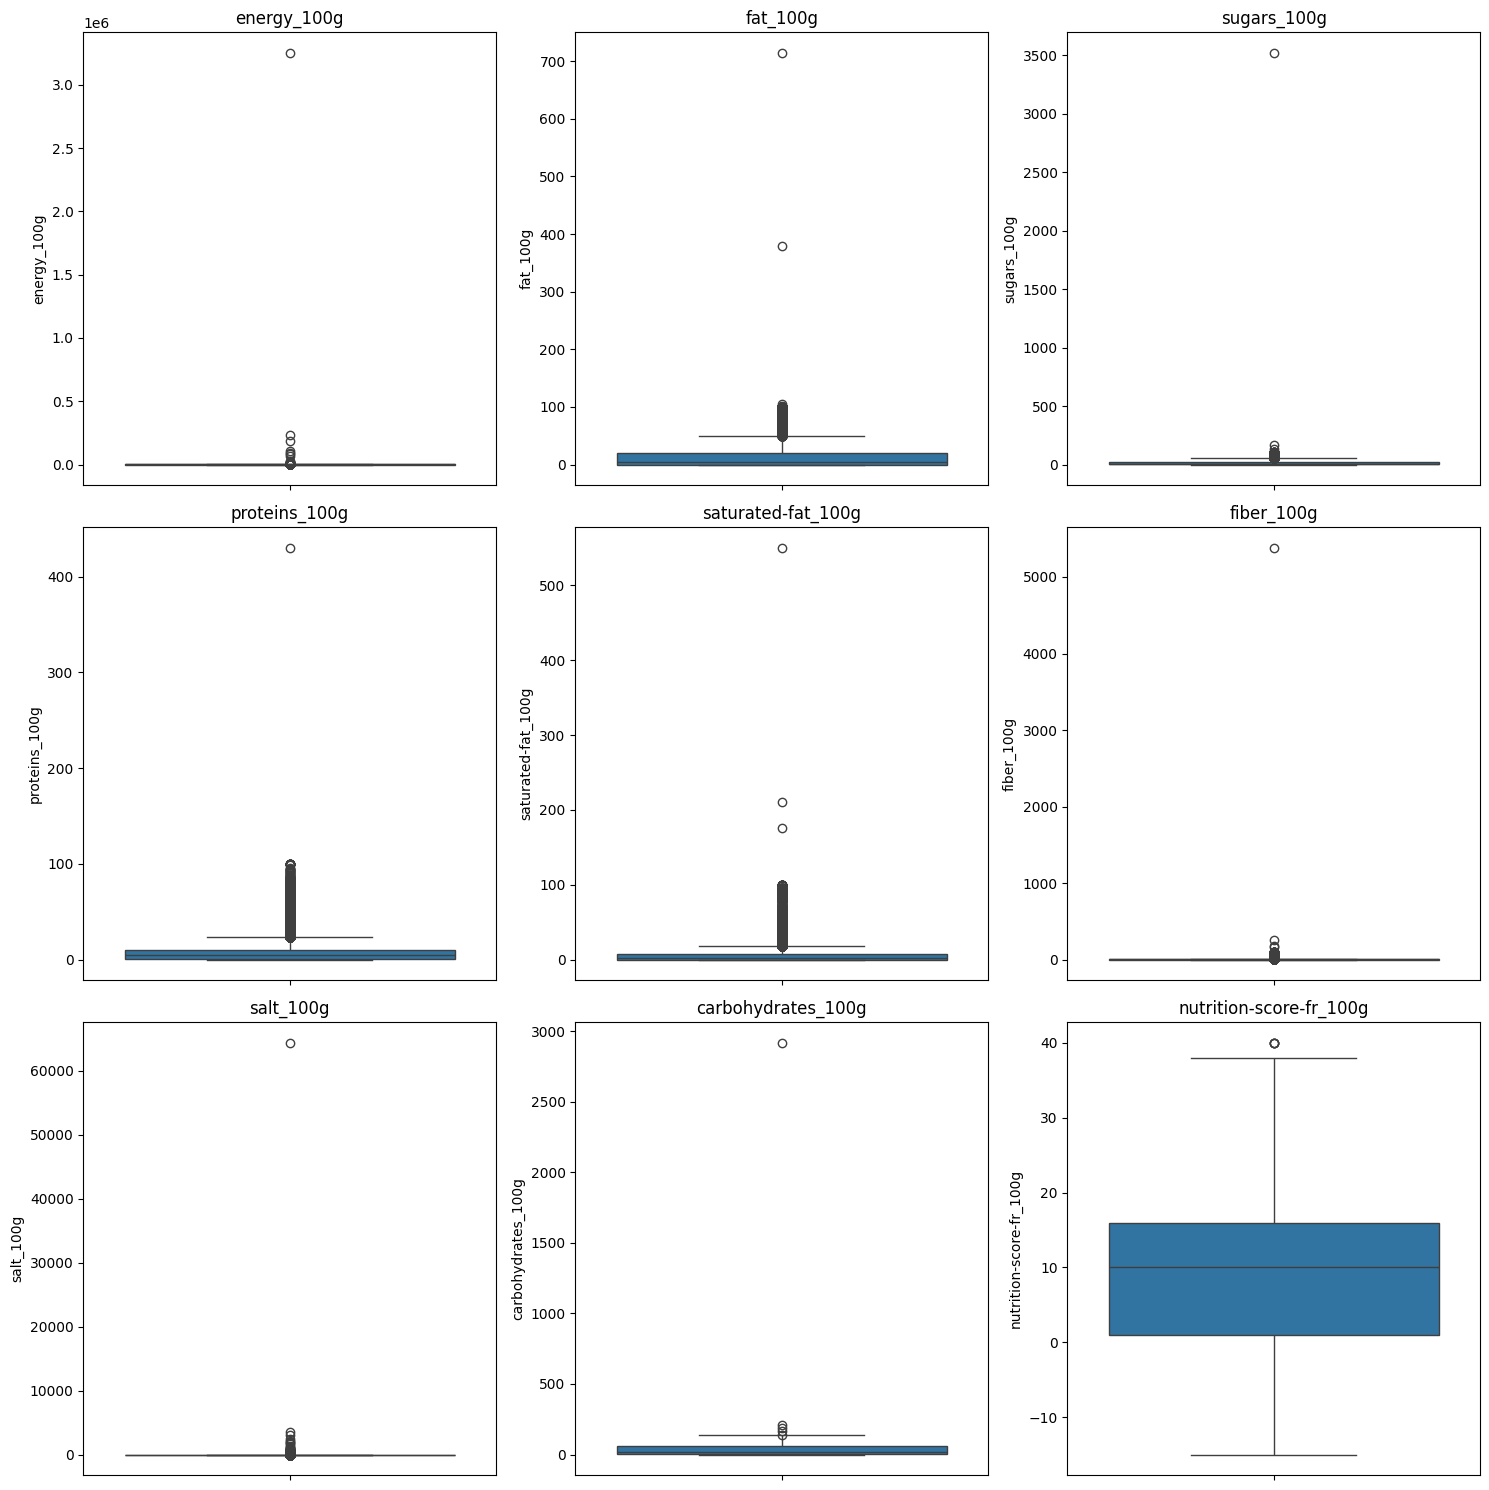

In [28]:
plot_boxplots(df_cleaned_neg)

### Showing quantity of outliers in each column

In [29]:
outliers = detect_outliers(df_cleaned_neg,q1=0.25, q3=0.75)
for col, count in outliers.items():
    print(f"Outliers in '{col}': {count}")

Outliers in 'energy_100g': 1080
Outliers in 'fat_100g': 8400
Outliers in 'sugars_100g': 15308
Outliers in 'proteins_100g': 12590
Outliers in 'saturated-fat_100g': 17247
Outliers in 'fiber_100g': 14127
Outliers in 'salt_100g': 16487
Outliers in 'carbohydrates_100g': 5
Outliers in 'nutrition-score-fr_100g': 4


## Replacing Outliers

### Energy Outliers

The formula for calculating the energy content of foods is:

`Energy (kJ) = (4 × Carbohydrates (g) + 4 × Proteins (g) + 9 × Fat (g)) × 4.184`

This formula assigns specific caloric values to macronutrients based on their average heat of combustion, accounting for digestion and absorption losses.

Before calculating energy values, we must first handle the missing data in the `'carbohydrates_100g'`, `'proteins_100g'`, and `'fat_100g'` columns.

**Outliers in the `energy_100g` column will be replaced later**, after missing data is filled.

---

### Other Outliers  

Other outliers will be replaced with the **highest reasonable value** based on known food data.  

**Maximum values per 100g of product:**

1. **`fat_100g` (fat, g)** — **79.3g** (e.g., mayonnaise)
2. **`sugars_100g` (sugars, g)** — **71.1g** (e.g., fruit paste)
3. **`proteins_100g` (proteins, g)** — **37.4g** (e.g., Graubünden meat)
4. **`saturated-fat_100g` (saturated fats, g)** — **30.9g** (e.g., fried coconut, dry almond)
5. **`fiber_100g` (fiber, g)** — **15.0g** (e.g., high-fiber breakfast cereals enriched with vitamins and minerals)
6. **`salt_100g` (salt, g)** — **5.9g** (e.g., mustard)
7. **`carbohydrates_100g` (carbohydrates, g)** — **88.4g** (e.g., baby cereals for 4-6 months).

### About nutrition-score-fr_100g

**`nutrition-score-fr_100g` (French nutrition score)** — Ranges from **-15** (healthiest products) to **+40** (high-calorie, low-nutrition products).

**So there are no outliers for this column.**


---

Sources:

- [MyFoodData](https://www.myfooddata.com/)  
- [Journal Santé](https://sante.journaldesfemmes.fr/)
- [Nutri-score](https://fr.wikipedia.org/wiki/Nutri-score?utm_source)

In [30]:
# Replacing choosed column with the highest reasonable value 

df_cleaned_neg['fat_100g'] = cap_values(df_cleaned_neg['fat_100g'], 79.3)
df_cleaned_neg['sugars_100g'] = cap_values(df_cleaned_neg['sugars_100g'], 71.1)
df_cleaned_neg['proteins_100g'] = cap_values(df_cleaned_neg['proteins_100g'], 37.4)
df_cleaned_neg['saturated-fat_100g'] = cap_values(df_cleaned_neg['saturated-fat_100g'], 30.9)
df_cleaned_neg['fiber_100g'] = cap_values(df_cleaned_neg['fiber_100g'], 15)
df_cleaned_neg['salt_100g'] = cap_values(df_cleaned_neg['salt_100g'],  5.9)
df_cleaned_neg['carbohydrates_100g'] = cap_values(df_cleaned_neg['carbohydrates_100g'], 88.4)

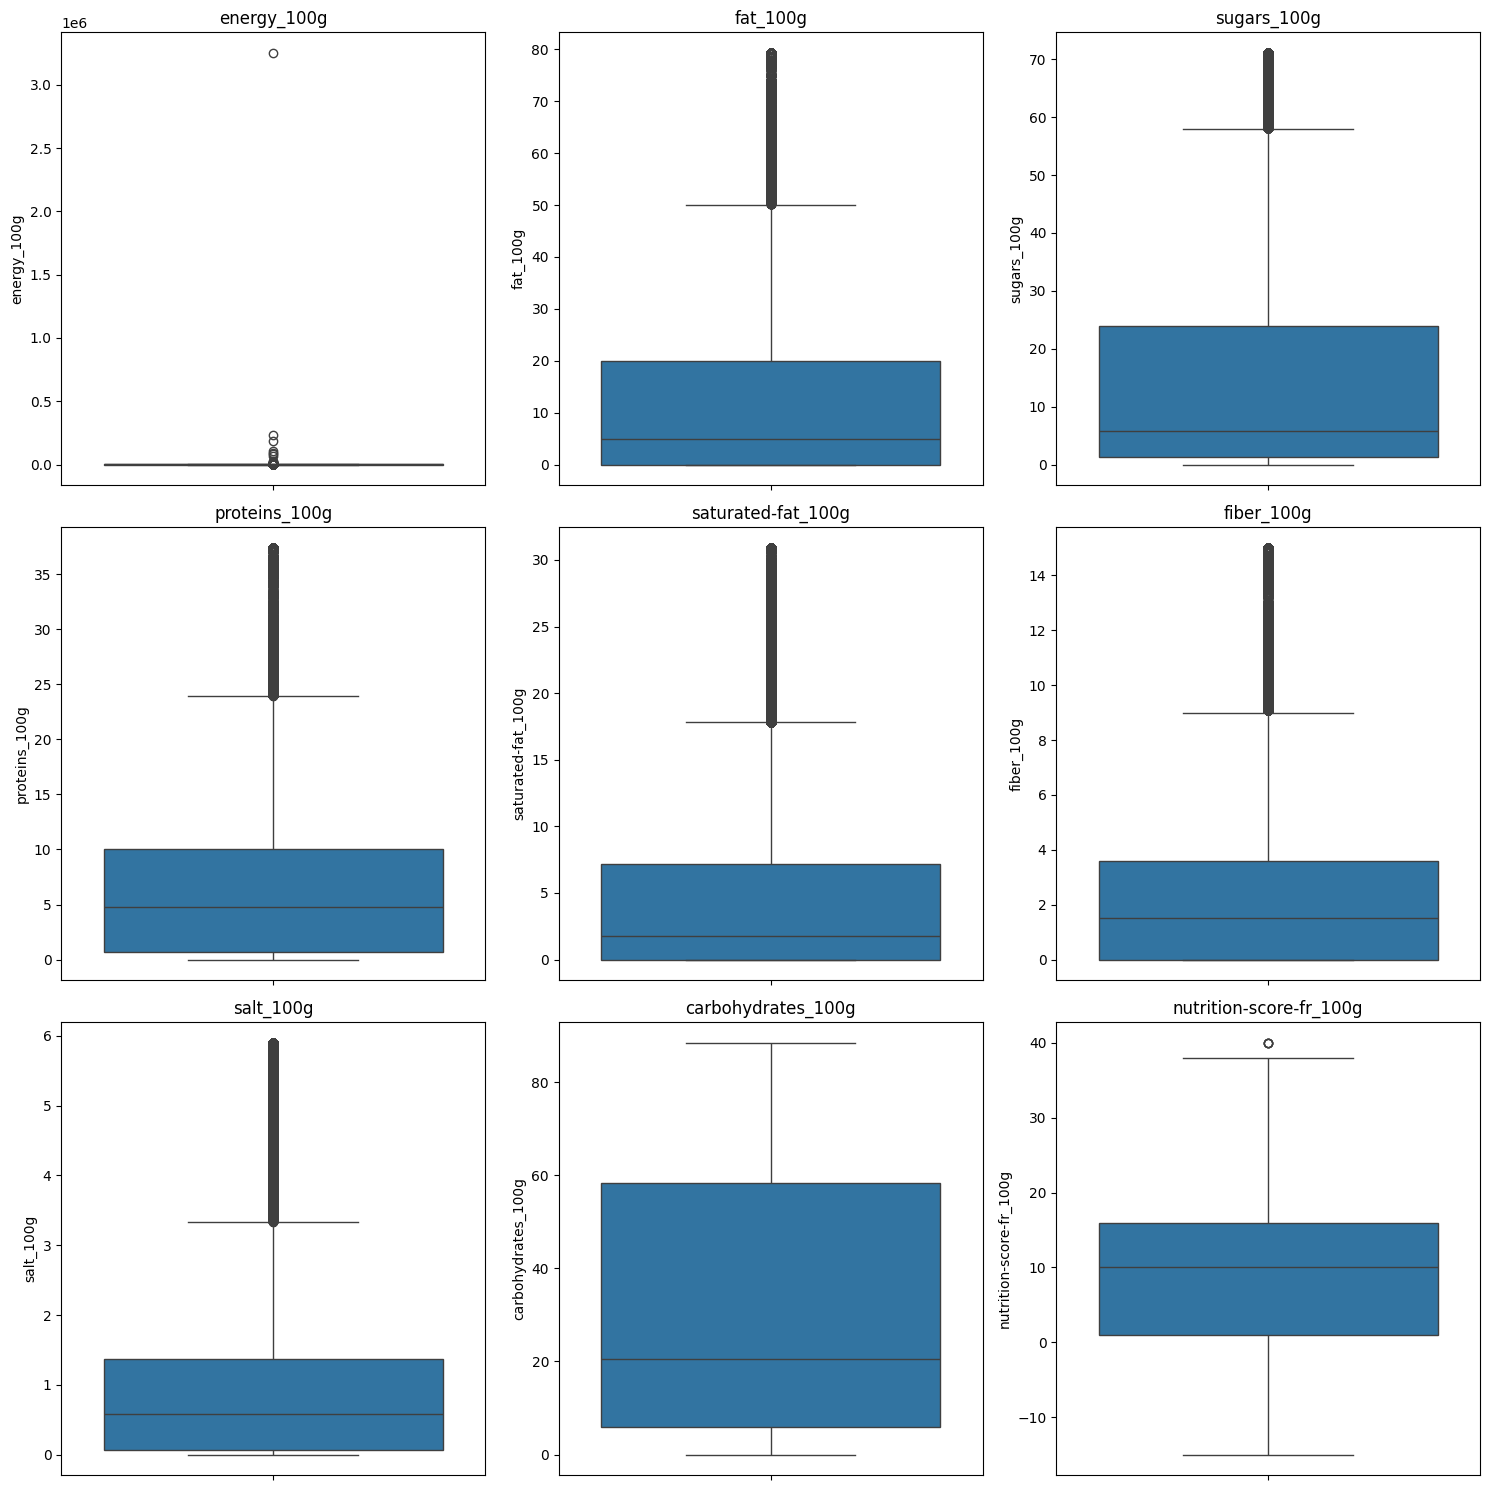

In [31]:
plot_boxplots(df_cleaned_neg)

### Calculating Energy



# 3️⃣ Step 3: Identify and handle missing values

____

## Removing rows with missing data in more than 10 columns

In [33]:
print_shape(df_cleaned_neg)


There are 320772 rows and 13 columns in the Data Frame.



<Axes: >

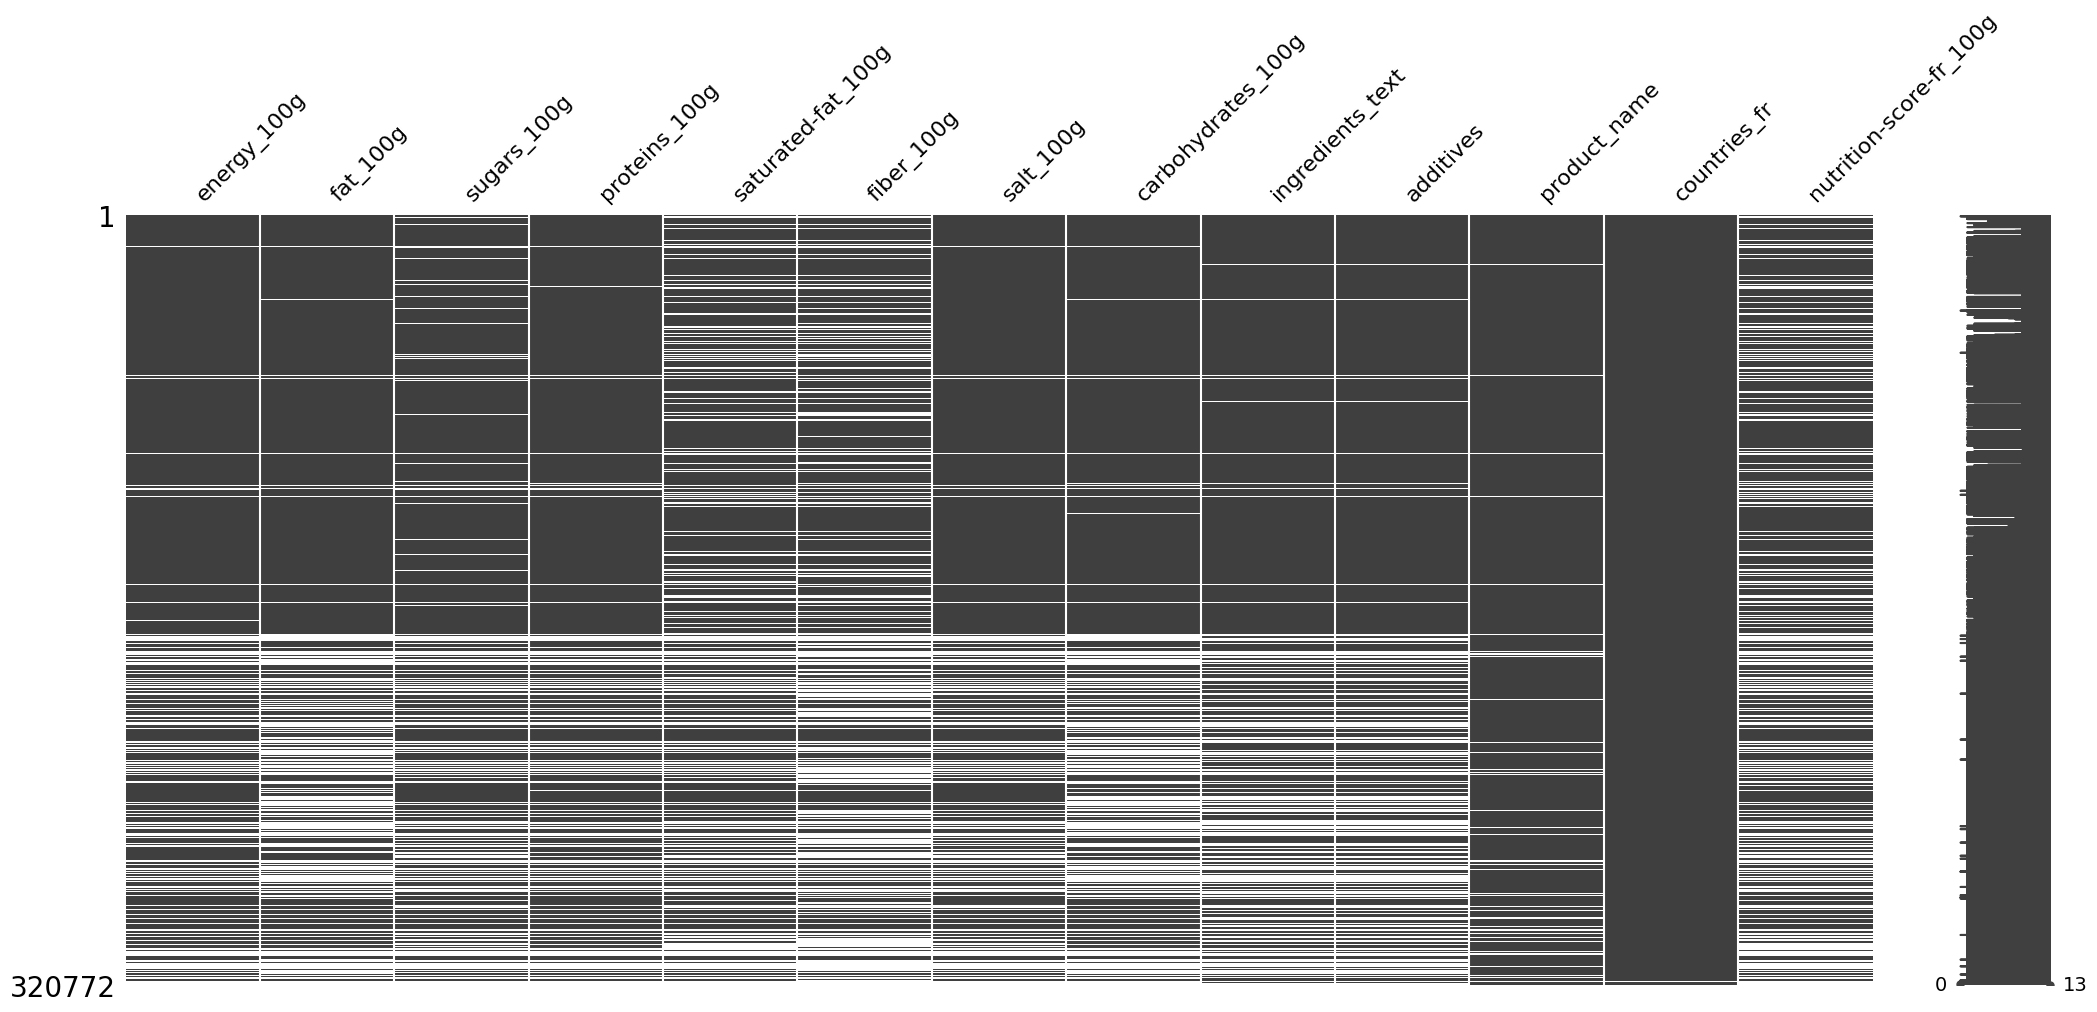

In [34]:
msno.matrix(df_cleaned_neg)

As we can see from the matrix plot, there are many rows with a significant amount of missing values across various columns. This indicates poor-quality data, which should be discarded, as it lacks meaningful information. 
**Therefore, our strategy is to identify rows with missing values in more than 10 columns and remove them.**


In [35]:
# Calling the function to delete rows with a significant amount of missing values. (in more than 10 columns)
df_cleaned_rows = delete_high_missing_rows(df_cleaned_neg)


44585 rows were deleted.


<Axes: >

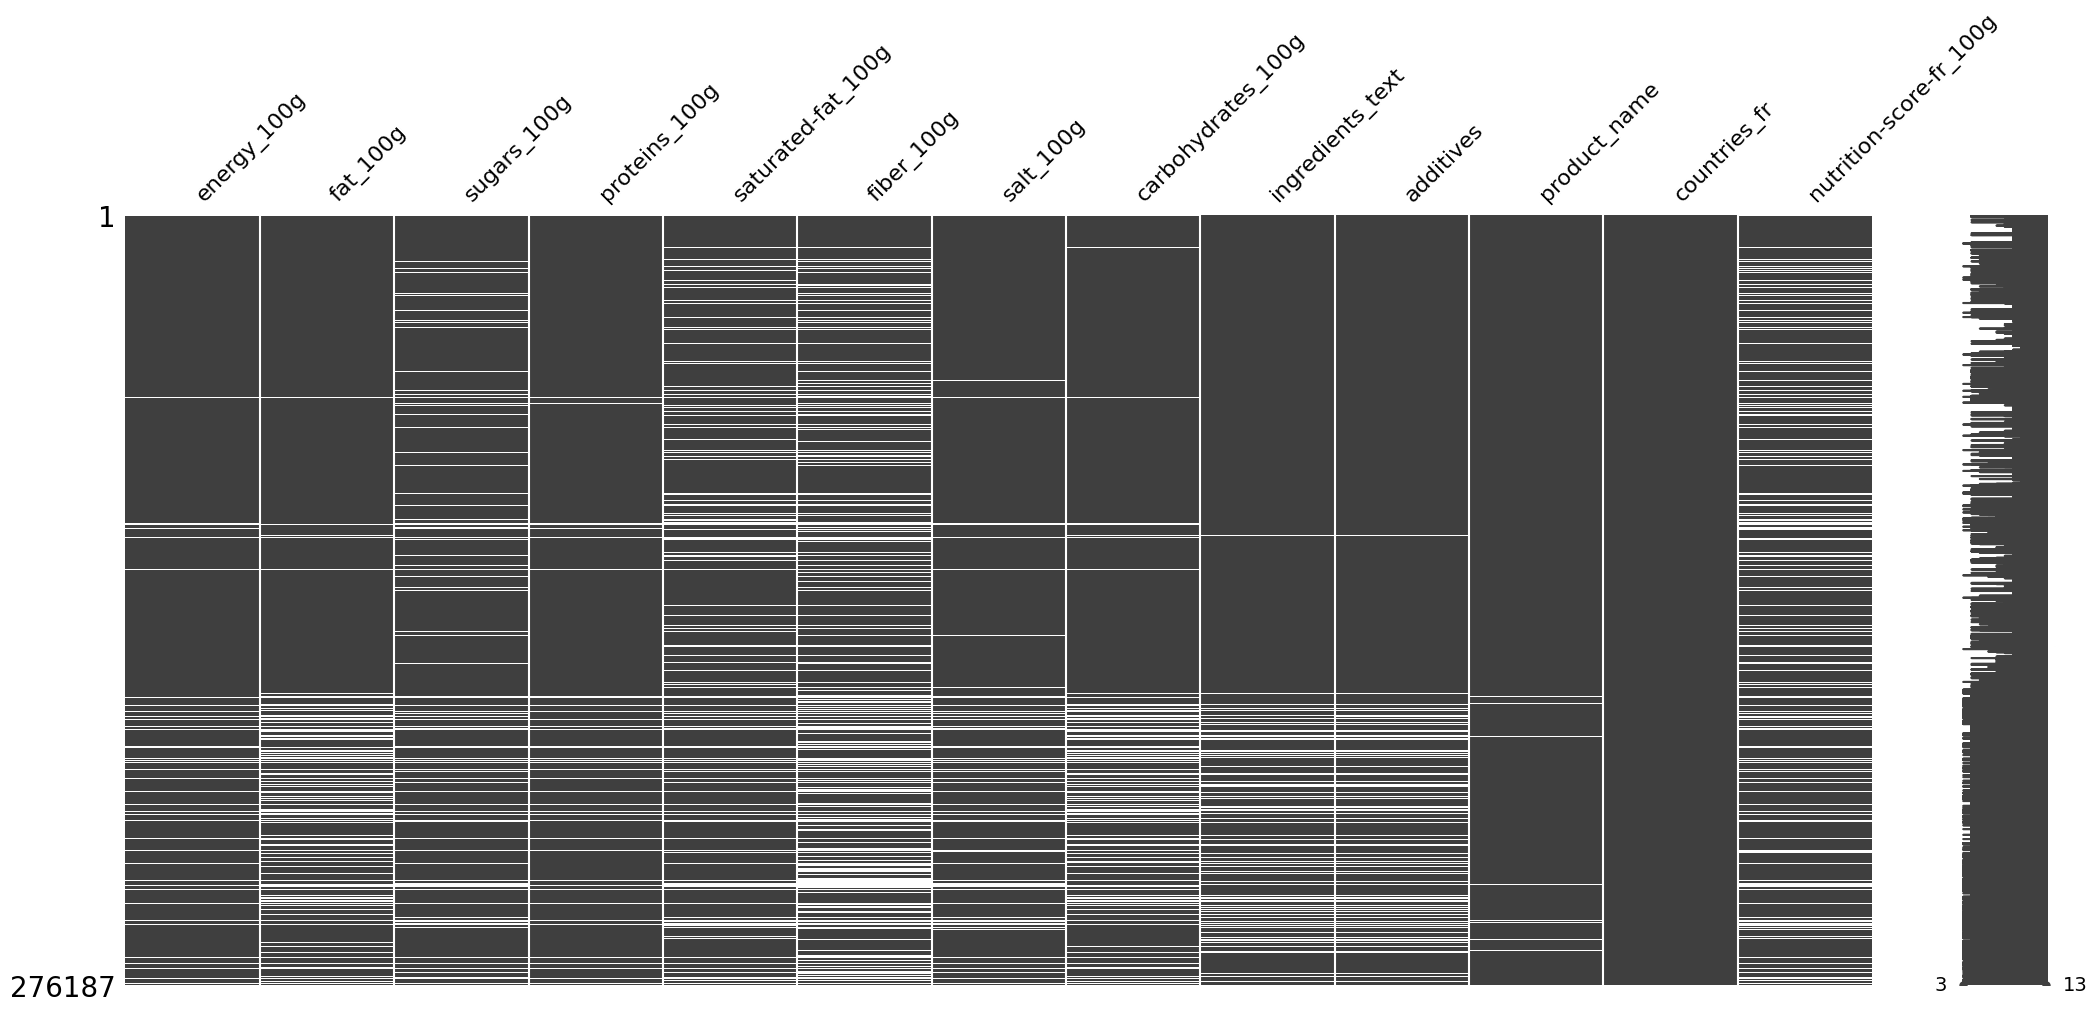

In [36]:
msno.matrix(df_cleaned_rows)

## Numerical data

In [37]:
df_filled_num = df_cleaned_rows.copy()

In [38]:
percent_missing(df_filled_num.select_dtypes(include='number'))

,Column,Percentage missing
0,fiber_100g,27.264860
1,nutrition-score-fr_100g,19.907164
2,saturated-fat_100g,16.884575
3,carbohydrates_100g,11.803235
4,fat_100g,11.693889
5,sugars_100g,11.305022
6,salt_100g,7.487318
7,proteins_100g,5.890212
8,energy_100g,5.460793


We used this approach to replace missing values (NaN) in the fiber_100g column for products containing specific keywords in their names (like “soda”, “oil”, “water”, etc.). By filtering rows based on these conditions, we ensure that only relevant products with missing fiber data are updated. This method directly modifies the fiber_100g column for the filtered rows, assigning them a value of 0, indicating the absence of fiber information.

In [76]:
df_filled_num = replace_fiber_with_zero(df_filled_num)


13256 rows were replaced with zeros sucsecefully!



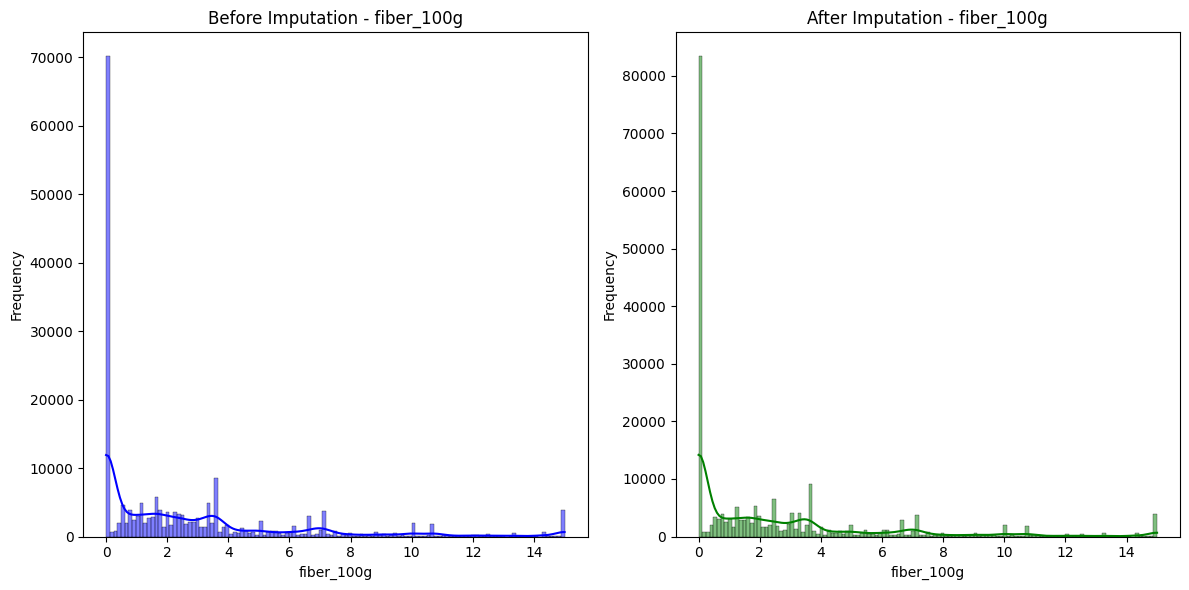

In [84]:
plot_distribution_before_after(df_cleaned_rows, df_filled_num, ['fiber_100g'])

### Data Replacement Strategy

1. For the columns:

- `fiber_100g` First we will filter and replace with 'zeros' and after fill missing values with median values
- `saturated-fat_100g` 
- `carbohydrates_100g`
- `fat_100g` 
- `sugars_100g` 
- `salt_100g`
- `proteins_100g` 
- `energy_100g`

  We will use the **median values** to fill the missing data for these columns. 

2. For the `energy_100g` column, we will fill the **data based on the formula for calculating energy**.
3. For `nutrition-score-fr_100g`, we will use the **KNN** method for replacement.


### Fill selected columns with median

In [ ]:
df_filled_num[['fiber_100g', 'saturated-fat_100g', 'carbohydrates_100g',
                                             'fat_100g', 'sugars_100g', 'salt_100g',
                                              'proteins_100g','energy_100g' 
                                             ]] = fill_missing_with_median(df_filled_num[['fiber_100g', 'saturated-fat_100g', 'carbohydrates_100g',
                                             'fat_100g', 'sugars_100g', 'salt_100g',
                                              'proteins_100g','energy_100g' 
                                             ]])

### Calculating energy to replace outliers and missing values

In [ ]:
df_filled_num['calculated_energy_100g'] = calculate_energy(df_filled_num)

In [ ]:
# Calculating the difference between energy_100g in Kj and our calculate_energy

df_filled_num['dif_energy_100g'] =  df_filled_num['energy_100g'] - df_filled_num['calculated_energy_100g'] 
df_filled_num[['energy_100g', 'calculated_energy_100g', 'dif_energy_100g']].describe().round(2)

According to nutritional data, the maximum energy content for high-fat products, like pure fats or oils (e.g., vegetable oil, butter), is around 3768 kJ (900 kcal) per 100 grams.

**This threshold is based on the fact that fat provides approximately 9 kcal (37.68 kJ) per gram, and 100 grams of pure fat would yield 900 kcal (3768 kJ).**

We now filter our dataset to identify rows where 'energy_100g' exceeds this maximum, indicating potential outliers — products with unusually high energy values that might result from data entry errors.


In [ ]:
# Looking at the impossible energy_100g (Too high values)

outliers_energy = df_filled_num[['product_name','energy_100g', 'calculated_energy_100g']][df_filled_num['energy_100g'] > 3768]
outliers_energy_len = len(df_filled_num[df_filled_num['energy_100g'] > 3768].index)

print(f'\nThere are {outliers_energy_len} lines wich contains outliers (more than 3768 kJ per 100 gr of product)\n')
outliers_energy.sample(15)

In [ ]:
# Remplace values of energy_100g to calculated_energy_100g for too high values
df_filled_num.loc[df_filled_num['energy_100g'] > 3768, 'energy_100g'] = df_filled_num['calculated_energy_100g']

In [ ]:
sns.boxplot(df_filled_num['energy_100g'])

In [ ]:
# Replacing missing values by calculated values

df_filled_num['energy_100g'] = df_filled_num['energy_100g'].fillna(df_filled_num['calculated_energy_100g'])

In [ ]:
df_filled = df_filled_num.drop(['calculated_energy_100g', 'dif_energy_100g'], axis=1)

In [ ]:
percent_missing(df_filled.select_dtypes(include='number'))

For numerical values, it left only **nutrition-score-fr_100g**, so let's fix it.

In [ ]:
# Looking for correlations with nutrition-score-fr_100g to find the best features to use with KNN imputer

correlation_matrix = df_filled.select_dtypes(include='number').corr().round(2)
nutrition_score_corr = correlation_matrix['nutrition-score-fr_100g']

nutrition_score_corr.sort_values()

In [ ]:
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")

### Using KNN Imputation

In [ ]:
# Select features
features_to_use = ['saturated-fat_100g', 'energy_100g', 'fat_100g', 'sugars_100g']

# Calling function with KNN method
df_filled = knn_impute(df_filled, 'nutrition-score-fr_100g', features_to_use)

In [ ]:
percent_missing(correlation_matrix)

## Categorical data

In [ ]:
percent_missing(df_cleaned_neg)

### Data Replacement Strategy

For the column `nutrition_grade_fr`, missing values will be filled with KNN method.

For the other categorical columns:

- Missing values in the `additives` column were replaced with the value "No additives".
- Missing values in the `ingredients_text` column were replaced with the value "Unknown ingredients".
- Missing values in the `product_name` column were replaced with the value "Unnamed product".

In [ ]:
df_filled_cat = df_filled.copy()

#### KNN method

In [ ]:
# Define mapping
grade_mapping = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5}

df_filled_cat = knn_impute(
    df_filled_cat,
    target_column='nutrition_grade_fr',
    features=['nutrition-score-fr_100g'],
    mapping=grade_mapping
)

In [ ]:
sns.countplot(x='nutrition_grade_fr', data=df_filled_cat,order=['a', 'b', 'c', 'd', 'e'], hue='nutrition_grade_fr', legend=False)
plt.title('Product Distribution by Nutrition Grade');

#### Fill with Unknown 

In [ ]:
df_filled_cat['additives'] = df_filled['additives'].fillna('No additives')

In [ ]:
df_filled_cat['ingredients_text'] = df_filled['ingredients_text'].fillna('Unknown ingredients')

In [ ]:
df_filled_cat['product_name'] = df_filled['product_name'].fillna('Unnamed product')

In [ ]:
percent_missing(df_filled_cat)

**After these replacements, all missing values in the dataframe were filled, and no missing values remained.**

In [ ]:
# Saving Data Frame

df_filled_cat.to_csv('processed_data_filled_categories.csv', index=False)

In [ ]:
df_ready = df_filled_cat

# 4️⃣ Step 4: Perform univariate and bivariate analyses

____

## Numerical data

### Univariate analyse

In [ ]:
numerical_columns = df_ready.select_dtypes(include='number').columns

In [ ]:
numerical_columns

In [ ]:
df_ready[numerical_columns].hist(bins=20, figsize=(15, 10))
plt.suptitle('Univariate Analysis - Numerical Data')
plt.tight_layout()

### Bivariate analyse

In [ ]:
for column in numerical_columns[0:-1]:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df_ready[column], y=df_ready['nutrition-score-fr_100g'])
    plt.title(f'Scatter plot of {column} vs. nutrition-score-fr_100g')

## Categorical data

### Univariate analyse

In [ ]:
categorical_columns = df_ready.select_dtypes(include='object').columns

In [ ]:
grade_counts = df_ready['nutrition_grade_fr'].value_counts().reindex(['a', 'b', 'c', 'd', 'e'])

custom_colors = ['#4CAF50', '#8BC34A', '#FFC107', '#FF5722', '#F44336'] 

plt.figure(figsize=(6, 6))
plt.pie(
    grade_counts,
    labels=grade_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=custom_colors,
    explode=[0, 0.1, 0, 0, 0] 
    
)
plt.title('Product Distribution by Nutrition Grade')
plt.axis('equal');

In [ ]:
sns.countplot(x='nutrition_grade_fr', data=df_ready, order=['a', 'b', 'c', 'd', 'e'], hue='nutrition_grade_fr', palette='Set1', legend=False)
plt.title('Product Distribution by Nutrition Grade');

### Bivariate analyse

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_ready['nutrition_grade_fr'], y=df_ready['nutrition-score-fr_100g'], order=['a', 'b', 'c', 'd', 'e'])
plt.title(f'Boxplot of nutrition_grade_fr vs. nutrition-score-fr_100g');

In [ ]:
df_ready.columns

# 5️⃣ Step 5: Perform multivariate analysis


____

## PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Scaling dada
scaled_data = StandardScaler().fit_transform(df_ready[numerical_columns])

# PCA with 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Adding data to df
df_ready['PCA1'] = pca_result[:, 0]
df_ready['PCA2'] = pca_result[:, 1]

# Set color
grade_order = ['a', 'b', 'c', 'd', 'e']
grade_colors = ['green', 'yellowgreen', 'yellow', 'orange', 'red']

# Plot PCA 
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='nutrition_grade_fr', data=df_ready, 
    hue_order=grade_order, palette=grade_colors, alpha=0.7
)
plt.title('Principal Component Analysis (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title="Nutrition Grade", loc="best")
plt.show();

In [ ]:
pca.components_

In [ ]:
# Plot heatmap
components_df = pd.DataFrame(pca.components_, columns=numerical_columns, index=['PCA1', 'PCA2'])

plt.figure(figsize=(12, 5))
sns.heatmap(components_df, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Impact of Features on Principal Components")
plt.xlabel("Features")
plt.ylabel("Principal Components"); 

- **PCA1** can be interpreted as a component that measures **the total energy and fat content** of foods. Foods with high values in this component are likely to be high in energy and fat.
- **PCA2** can reflect **the balance of carbohydrates and sugars** in a food, with positive values associated **with high levels of sugar and carbohydrate**s and **negative values with low levels of fat and protein**.

## Nutrient values vs Nutrient grade

In [ ]:
grade_groups = df_ready.groupby('nutrition_grade_fr')[['sugars_100g', 'fat_100g', 'proteins_100g', 'fiber_100g']].mean()

grade_groups.plot(kind='bar', figsize=(10, 6))
plt.title('Average Nutrient Values by Nutrition Grade')
plt.xticks(rotation=360)
plt.ylabel('Content per 100g'); 

In [ ]:
grade_groups